**IMPORTING ALL THE NECESSARY LIBRARIES******

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

2025-07-14 14:06:40.530378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752502000.552848     950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752502000.559977     950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**IMAGE PREPROCESSING**
*1.1 Crop distribution*

In [2]:
# Dataset analysis
DATASET_DIR = "/kaggle/input/crop-disease-dataset/disease/train"
class_counts = {}
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)

print("----------------------Class Distribution:--------------------------\n")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Total images and classes calculation
total_images = sum(class_counts.values())
n_classes = len(class_counts)
print(f"\n----------------------------------Dataset Summary:-----------------------")
print(f"Total images: {total_images}")
print(f"Number of classes: {n_classes}")
print(f"Average images per class: {total_images/n_classes:.1f}")


----------------------Class Distribution:--------------------------

Tomato___Late_blight: 1851 images
Tomato___healthy: 1926 images
Potato___healthy: 1824 images
Corn_(maize)___Northern_Leaf_Blight: 1908 images
Tomato___Early_blight: 1920 images
Tomato___Septoria_leaf_spot: 1745 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
Apple___Apple_scab: 2016 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 images
Tomato___Bacterial_spot: 1702 images
Apple___Black_rot: 2027 images
Apple___Cedar_apple_rust: 1760 images
Tomato___Target_Spot: 1827 images
Pepper,_bell___healthy: 1988 images
Potato___Late_blight: 1939 images
Tomato___Tomato_mosaic_virus: 1790 images
Apple___healthy: 2008 images
Potato___Early_blight: 1939 images
Corn_(maize)___Common_rust_: 1948 images
Tomato___Leaf_Mold: 1882 images
Tomato___Spider_mites Two-spotted_spider_mite: 1741 images
Pepper,_bell___Bacterial_spot: 1913 images
Corn_(maize)___healthy: 1859 images

----------------------------------Da

In [3]:
# Find min and max class sizes
min_images = min(class_counts.values())
max_images = max(class_counts.values())
min_class_name = min(class_counts, key=class_counts.get)
max_class_name = max(class_counts, key=class_counts.get)
print(f"Smallest class \n{min_class_name}=> {min_images} images\n")
print(f"Largest class \n{max_class_name}=> {max_images} images\n")


Smallest class 
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot=> 1642 images

Largest class 
Apple___Black_rot=> 2027 images



*Check for duplicates*

In [4]:
print("-------------------Counting images in each class----------------------------------")
image_extensions=('.jpg', '.jpeg', '.png')      
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) 
        if f.lower().endswith(image_extensions)]
        class_counts[class_name] = len(images)
print(class_counts)

-------------------Counting images in each class----------------------------------
{'Tomato___Late_blight': 1851, 'Tomato___healthy': 1926, 'Potato___healthy': 1824, 'Corn_(maize)___Northern_Leaf_Blight': 1908, 'Tomato___Early_blight': 1920, 'Tomato___Septoria_leaf_spot': 1745, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642, 'Apple___Apple_scab': 2016, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1961, 'Tomato___Bacterial_spot': 1702, 'Apple___Black_rot': 2027, 'Apple___Cedar_apple_rust': 1760, 'Tomato___Target_Spot': 1827, 'Pepper,_bell___healthy': 1988, 'Potato___Late_blight': 1939, 'Tomato___Tomato_mosaic_virus': 1790, 'Apple___healthy': 2008, 'Potato___Early_blight': 1939, 'Corn_(maize)___Common_rust_': 1948, 'Tomato___Leaf_Mold': 1882, 'Tomato___Spider_mites Two-spotted_spider_mite': 1741, 'Pepper,_bell___Bacterial_spot': 1913, 'Corn_(maize)___healthy': 1859}


In [5]:
# Dataset balance analysis
if class_counts: 
    counts = list(class_counts.values())
    total_images = sum(counts)
    n_classes = len(class_counts)
    
    analysis_results = {
        'total_images': total_images,
        'n_classes': n_classes,
        'average_per_class': total_images / n_classes,
        'min_images': min(counts),
        'max_images': max(counts),
        'std_dev': np.std(counts),
        'median': np.median(counts)
    }
    
    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)
    
    analysis_results['min_class'] = min_class
    analysis_results['max_class'] = max_class
    
    imbalance_ratio = analysis_results['max_images'] / analysis_results['min_images']
    analysis_results['imbalance_ratio'] = imbalance_ratio
    
    if imbalance_ratio < 2:
        balance_status = "Well Balanced"
    elif imbalance_ratio < 5:
        balance_status = "Slightly Imbalanced"
    elif imbalance_ratio < 10:
        balance_status = "Moderately Imbalanced"
    else:
        balance_status = "Severely Imbalanced"
    
    analysis_results['balance_status'] = balance_status
    
    print("--------------Analysis results------------------")
    print(analysis_results)
else:
    print("No classes found in the dataset!")


--------------Analysis results------------------
{'total_images': 43116, 'n_classes': 23, 'average_per_class': 1874.608695652174, 'min_images': 1642, 'max_images': 2027, 'std_dev': 103.59315871755861, 'median': 1908.0, 'min_class': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'max_class': 'Apple___Black_rot', 'imbalance_ratio': 1.2344701583434836, 'balance_status': 'Well Balanced'}


**Visualisations**

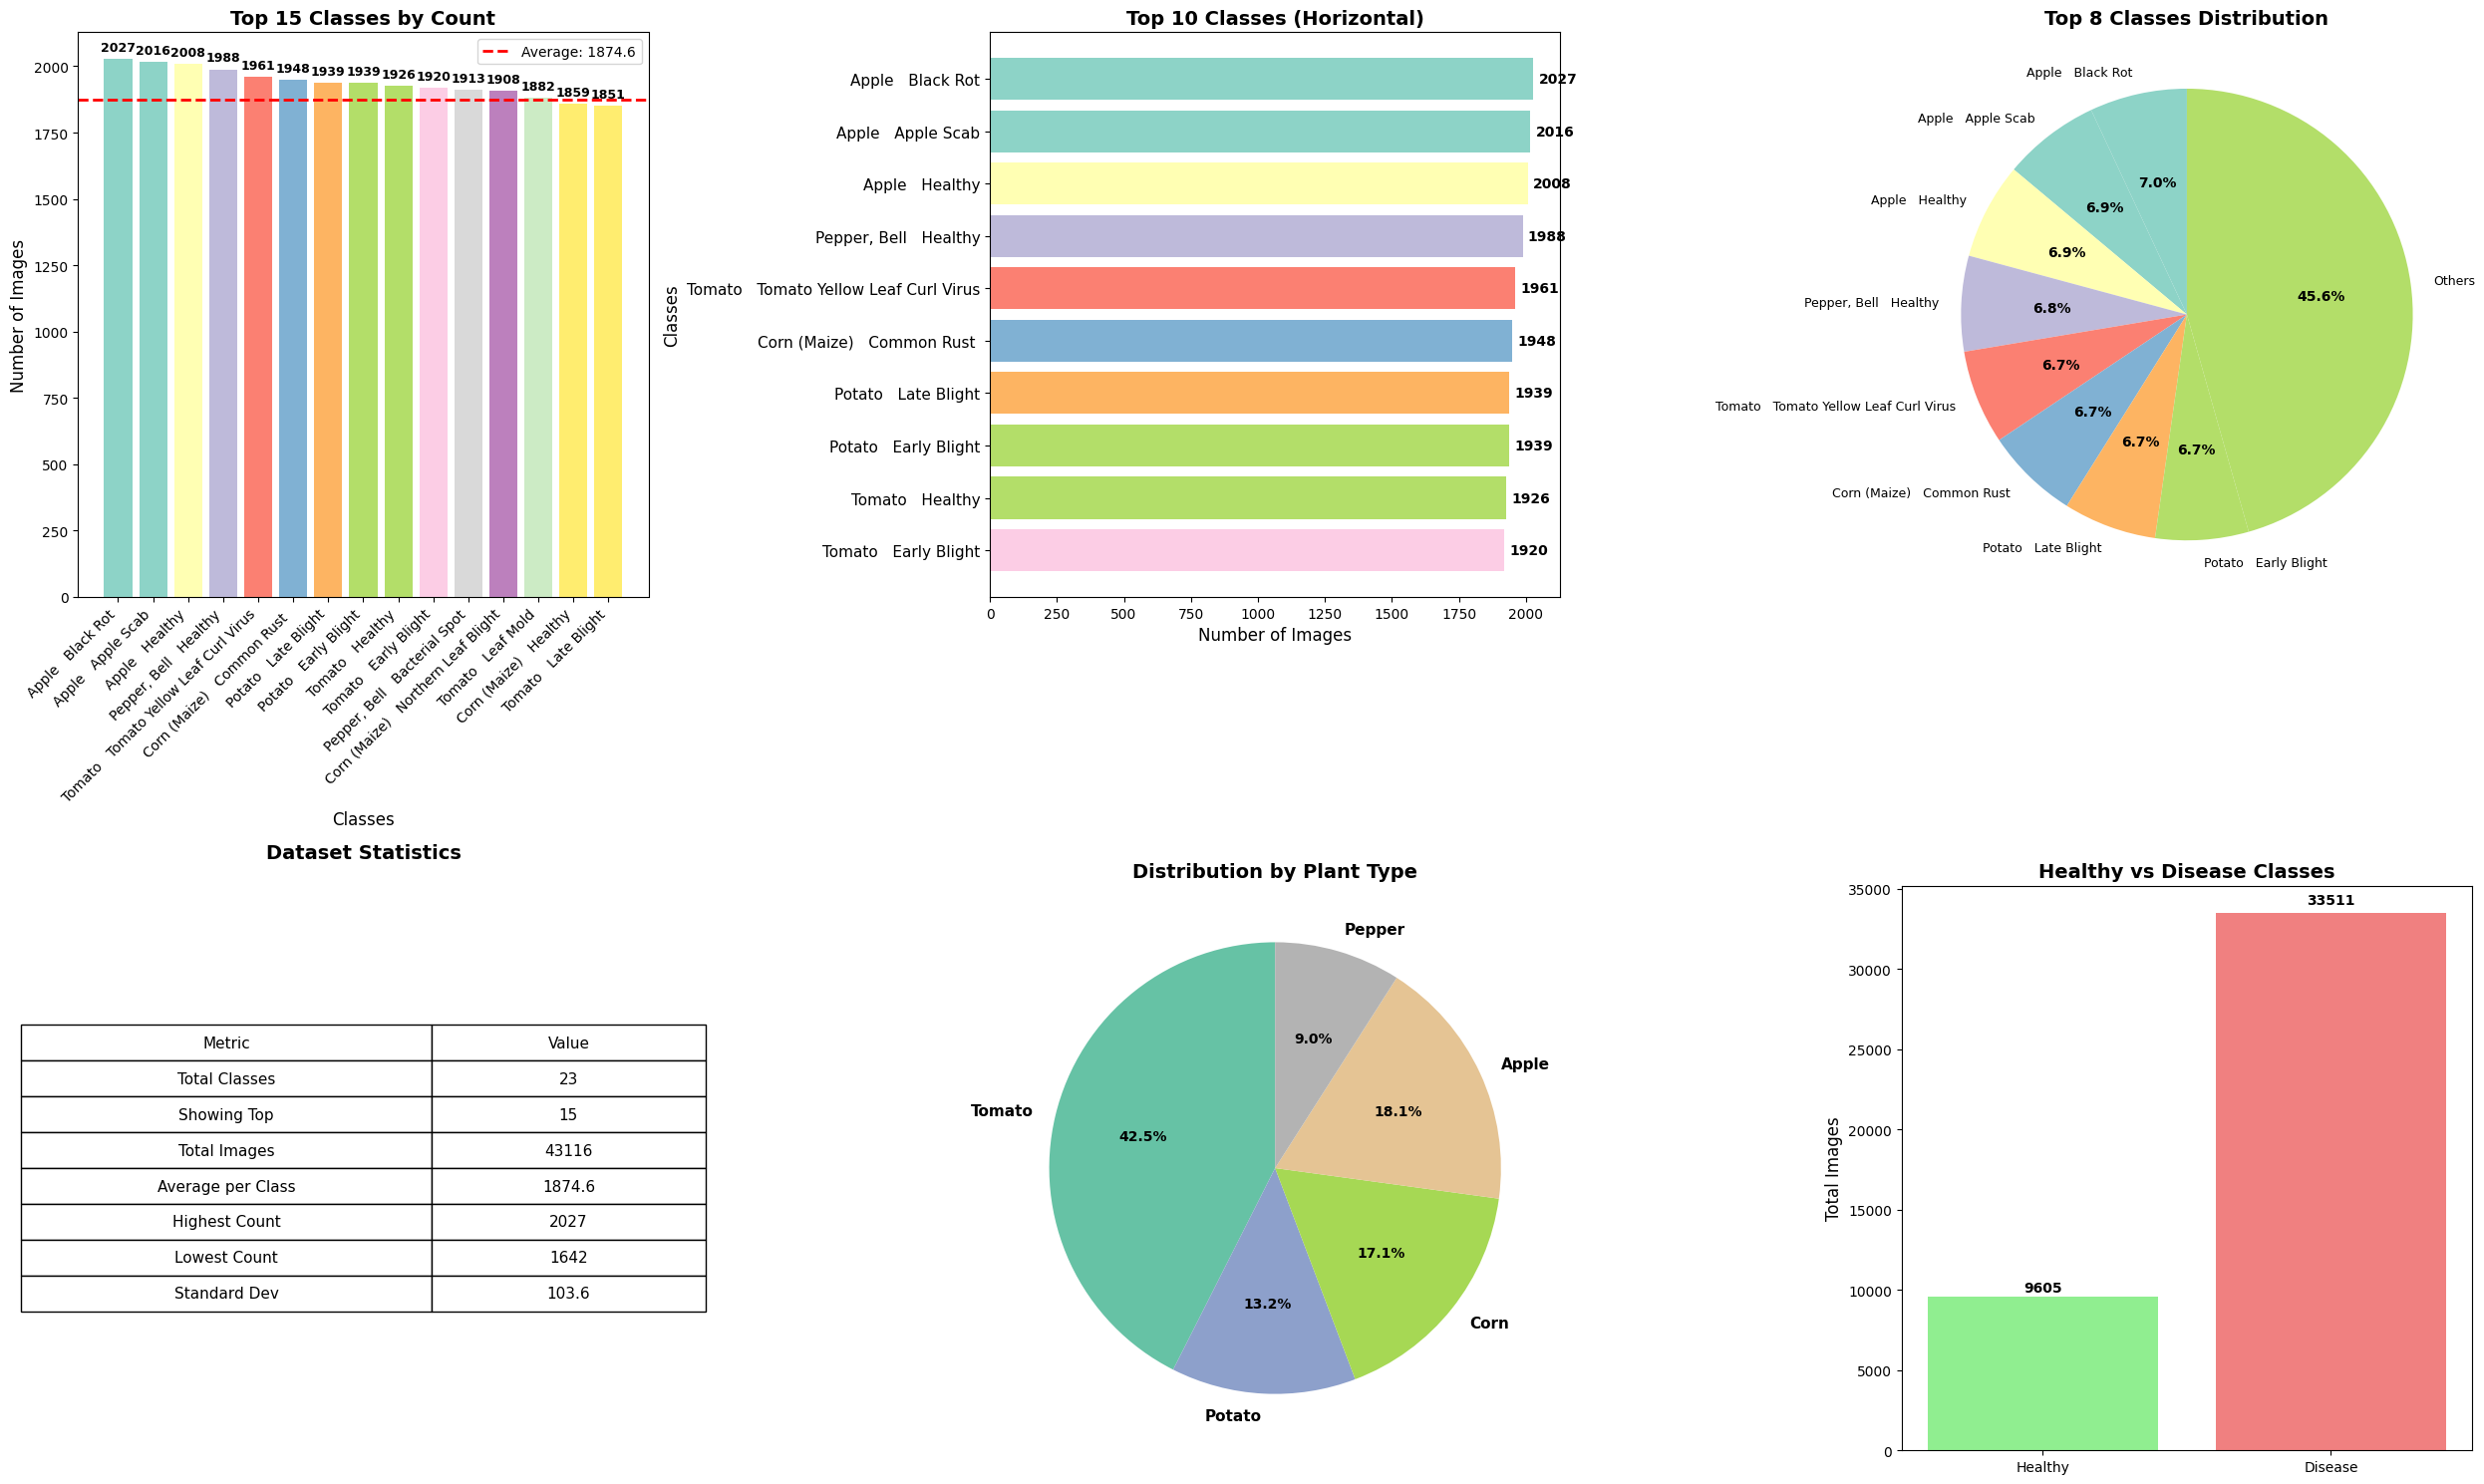

In [6]:
#figure with multiple subplots
fig = plt.figure(figsize=(25, 15))

# Sort classes by count for better visualization(SHOW ONLY TOP 15)
sorted_classes = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:15])
class_names = list(sorted_classes.keys())
class_values = list(sorted_classes.values())

# Clean up class names(better readability)
clean_class_names = [name.replace('_', ' ').title() for name in class_names]

# Color scheme
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

# Main bar plot - sorted by count (TOP 15 ONLY)
ax1 = plt.subplot(2, 3, 1)
bars1 = ax1.bar(range(len(class_names)), class_values, color=colors)
ax1.set_title('Top 15 Classes by Count', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classes', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xticks(range(len(class_names)))
ax1.set_xticklabels(clean_class_names, rotation=45, ha='right', fontsize=10)

# value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

#average line
avg_line = analysis_results['average_per_class']
ax1.axhline(y=avg_line, color='red', linestyle='--', linewidth=2, 
            label=f'Average: {avg_line:.1f}')
ax1.legend()

# Horizontal bar plot(TOP 10 ONLY)
ax2 = plt.subplot(2, 3, 2)
top_10_names = class_names[:10]
top_10_values = class_values[:10]
top_10_clean = clean_class_names[:10]

bars2 = ax2.barh(range(len(top_10_names)), top_10_values, color=colors[:10])
ax2.set_title('Top 10 Classes (Horizontal)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Images', fontsize=12)
ax2.set_ylabel('Classes', fontsize=12)
ax2.set_yticks(range(len(top_10_names)))
ax2.set_yticklabels(top_10_clean, fontsize=11)
ax2.invert_yaxis()  # Highest count at top

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
            f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=10)

# Pie chart (TOP 8 ONLY )
ax3 = plt.subplot(2, 3, 3)
top_8_names = clean_class_names[:8]
top_8_values = class_values[:8]
other_sum = sum(class_values[8:])

if other_sum > 0:
    pie_names = top_8_names + ['Others']
    pie_values = top_8_values + [other_sum]
else:
    pie_names = top_8_names
    pie_values = top_8_values

wedges, texts, autotexts = ax3.pie(pie_values, labels=pie_names, autopct='%1.1f%%',
                                   colors=colors[:len(pie_values)], startangle=90)
ax3.set_title('Top 8 Classes Distribution', fontsize=14, fontweight='bold')

# Make percentage text bold and adjust font size
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Adjust label font size
for text in texts:
    text.set_fontsize(9)

# Statistics summary
ax4 = plt.subplot(2, 3, 4)
ax4.axis('off')

# Create a clean statistics table
stats_data = [
    ['Total Classes', len(class_counts)],
    ['Showing Top', len(class_names)],
    ['Total Images', sum(class_counts.values())],
    ['Average per Class', f'{analysis_results["average_per_class"]:.1f}'],
    ['Highest Count', max(class_counts.values())],
    ['Lowest Count', min(class_counts.values())],
    ['Standard Dev', f'{analysis_results.get("std_dev", 0):.1f}']
]

table = ax4.table(cellText=stats_data,
                  colLabels=['Metric', 'Value'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

ax4.set_title('Dataset Statistics', fontsize=14, fontweight='bold', pad=20)

# Plant type grouping (if applicable)
ax5 = plt.subplot(2, 3, 5)
plant_groups = {}
for class_name, count in class_counts.items():
    if any(word in class_name.lower() for word in ['apple']):
        plant_type = 'Apple'
    elif any(word in class_name.lower() for word in ['tomato']):
        plant_type = 'Tomato'
    elif any(word in class_name.lower() for word in ['corn']):
        plant_type = 'Corn'
    elif any(word in class_name.lower() for word in ['potato']):
        plant_type = 'Potato'
    elif any(word in class_name.lower() for word in ['pepper']):
        plant_type = 'Pepper'
    else:
        plant_type = 'Other'
    
    if plant_type not in plant_groups:
        plant_groups[plant_type] = 0
    plant_groups[plant_type] += count

if len(plant_groups) > 1:
    wedges2, texts2, autotexts2 = ax5.pie(plant_groups.values(), 
                                          labels=plant_groups.keys(), 
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=plt.cm.Set2(np.linspace(0, 1, len(plant_groups))))
    ax5.set_title('Distribution by Plant Type', fontsize=14, fontweight='bold')
    
    for text in texts2:
        text.set_fontsize(11)
        text.set_fontweight('bold')
    for autotext in autotexts2:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
else:
    ax5.text(0.5, 0.5, 'Single Plant Type\nDataset', ha='center', va='center', 
             fontsize=14, fontweight='bold', transform=ax5.transAxes)
    ax5.set_title('Plant Type Analysis', fontsize=14, fontweight='bold')

# Balance analysis
ax6 = plt.subplot(2, 3, 6)
healthy_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' in class_name.lower())
disease_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' not in class_name.lower())

if healthy_count > 0 and disease_count > 0:
    categories = ['Healthy', 'Disease']
    counts = [healthy_count, disease_count]
    colors_balance = ['lightgreen', 'lightcoral']
    
    bars6 = ax6.bar(categories, counts, color=colors_balance)
    ax6.set_title('Healthy vs Disease Classes', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Total Images', fontsize=12)
    
    for i, bar in enumerate(bars6):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No Healthy/Disease\nClassification Available', 
             ha='center', va='center', fontsize=12, fontweight='bold', 
             transform=ax6.transAxes)
    ax6.set_title('Class Balance Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
EPOCHS = 30
BATCH_SIZE = 64  # Increased from 32 for better stability
IMG_SIZE = 224
TRAIN_DIR = "/kaggle/input/crop-disease-dataset/disease/train"
VALID_DIR = "/kaggle/input/crop-disease-dataset/disease/valid"
TEST_DIR = "/kaggle/input/crop-disease-dataset/disease/test"

In [8]:
all_valid_classes = os.listdir(VALID_DIR)
print(f"All validation classes ({len(all_valid_classes)}):")
for i, cls in enumerate(all_valid_classes):
    print(f"{i+1}. {cls}")

# Define classes to keep
classes_to_keep = [
    'Tomato___Late_blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Corn_(maize)___Common_rust_',
    'Potato___Early_blight', 'Apple___healthy', 'Tomato___Tomato_mosaic_virus', 'Potato___Late_blight',
    'Pepper,_bell___healthy', 'Tomato___Target_Spot', 'Apple___Cedar_apple_rust', 'Apple___Black_rot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Apple_scab',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Septoria_leaf_spot',
    'Tomato___Early_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___healthy', 'Tomato___healthy'
]

print(len(classes_to_keep))

All validation classes (38):
1. Tomato___Late_blight
2. Tomato___healthy
3. Grape___healthy
4. Orange___Haunglongbing_(Citrus_greening)
5. Soybean___healthy
6. Squash___Powdery_mildew
7. Potato___healthy
8. Corn_(maize)___Northern_Leaf_Blight
9. Tomato___Early_blight
10. Tomato___Septoria_leaf_spot
11. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
12. Strawberry___Leaf_scorch
13. Peach___healthy
14. Apple___Apple_scab
15. Tomato___Tomato_Yellow_Leaf_Curl_Virus
16. Tomato___Bacterial_spot
17. Apple___Black_rot
18. Blueberry___healthy
19. Cherry_(including_sour)___Powdery_mildew
20. Peach___Bacterial_spot
21. Apple___Cedar_apple_rust
22. Tomato___Target_Spot
23. Pepper,_bell___healthy
24. Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
25. Potato___Late_blight
26. Tomato___Tomato_mosaic_virus
27. Strawberry___healthy
28. Apple___healthy
29. Grape___Black_rot
30. Potato___Early_blight
31. Cherry_(including_sour)___healthy
32. Corn_(maize)___Common_rust_
33. Grape___Esca_(Black_Measles)
34

In [9]:
crop_classes = len(classes_to_keep)
print(f"Number of classes to train on: {crop_classes}")

Number of classes to train on: 23


In [10]:
# Model building with distributed strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 2


I0000 00:00:1752502054.178307     950 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752502054.178973     950 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
# Enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 43116 images belonging to 23 classes.
Found 10758 images belonging to 23 classes.
Found 0 images belonging to 0 classes.


In [13]:
# Get number of classes
crop_classes = len(train_generator.class_indices)
print(f"Number of classes: {crop_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 23
Class indices: {'Tomato___Late_blight': 0, 'Corn_(maize)___healthy': 1, 'Pepper,_bell___Bacterial_spot': 2, 'Tomato___Spider_mites Two-spotted_spider_mite': 3, 'Tomato___Leaf_Mold': 4, 'Corn_(maize)___Common_rust_': 5, 'Potato___Early_blight': 6, 'Apple___healthy': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Potato___Late_blight': 9, 'Pepper,_bell___healthy': 10, 'Tomato___Target_Spot': 11, 'Apple___Cedar_apple_rust': 12, 'Apple___Black_rot': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Apple_scab': 16, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 17, 'Tomato___Septoria_leaf_spot': 18, 'Tomato___Early_blight': 19, 'Corn_(maize)___Northern_Leaf_Blight': 20, 'Potato___healthy': 21, 'Tomato___healthy': 22}


In [14]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {validation_generator.samples}")
print(f"Number of classes: {len(classes_to_keep)}")


Training samples: 43116
Validation samples: 10758
Test samples: 10758
Number of classes: 23


In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_names = sorted(os.listdir(VALID_DIR))
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

labels = []
for class_name in class_names:
    class_folder = os.path.join(VALID_DIR, class_name)
    image_files = os.listdir(class_folder)
    label_index = class_to_index[class_name]
    labels.extend([label_index] * len(image_files))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.9175020885547202, 1: 0.9304246531822514, 2: 1.050956937799043, 3: 0.921157475361711, 4: 1.0185485740783677, 5: 1.0983872984123015, 6: 1.0140812557710064, 7: 1.1278562259306804, 8: 0.9694361690389496, 9: 0.9694361690389496, 10: 0.9944538766270515, 11: 0.9797056199821588, 12: 0.9633771929824562, 13: 1.0753977968176254, 14: 1.0931939778524324, 15: 0.9193261483729204, 16: 1.0074532737071438, 17: 1.0704191033138402, 18: 0.9674080598987007, 19: 0.9304246531822514, 20: 0.9534454693434617, 21: 0.9534454693434617, 22: 1.0140812557710064, 23: 1.0391484328799527, 24: 0.9156852527357999, 25: 1.0654862963861267, 26: 1.041488857278331, 27: 1.0140812557710064, 28: 1.0880495356037152, 29: 0.9633771929824562, 30: 0.9987495737183131, 31: 0.9838745800671892, 32: 1.0605987445678415, 33: 1.0630369026013309, 34: 1.0118622595877, 35: 0.9437164339419979, 36: 1.0321898496240602, 37: 0.9613743297953824}


**MODEL ARCHITECTURE**

In [16]:
def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(len(classes_to_keep), activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,039 (1.76 MB)

 Trainable params: 461,079 (1.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,039 (1.76 MB)

 Trainable params: 461,079 (1.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

**DEFINE CALLBACKS**

In [19]:
#call backs
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Increased from 3
        min_delta=0.001,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

**TRAIN THE MODEL**

In [20]:
#train the model on the training dataset on vaalidation data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752502137.879251     990 service.cc:148] XLA service 0x784bec217fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752502137.879290     990 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752502137.879295     990 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752502138.428927     990 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/674 ━━━━━━━━━━━━━━━━━━━━ 3:11:21 17s/step - accuracy: 0.0938 - loss: 6.1281

I0000 00:00:1752502148.951301     990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4761 - loss: 2.9891
Epoch 1: val_accuracy improved from -inf to 0.42145, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 814s 1s/step - accuracy: 0.4763 - loss: 2.9875 - val_accuracy: 0.4215 - val_loss: 2.3131 - learning_rate: 0.0010
Epoch 2/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.7848 - loss: 0.8586
Epoch 2: val_accuracy improved from 0.42145 to 0.69353, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 670s 994ms/step - accuracy: 0.7848 - loss: 0.8585 - val_accuracy: 0.6935 - val_loss: 1.1686 - learning_rate: 0.0010
Epoch 3/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.8607 - loss: 0.6076
Epoch 3: val_accuracy improved from 0.69353 to 0.77087, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 669s 992ms/step - accuracy: 0.8607 - loss: 0.6075 - val_accuracy: 0.7709 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 4/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accurac

**SAVE THE MODEL**

In [22]:
model.save("crop_disease_model.keras")
model.save("crop_disease_model.h5")
model.save('/kaggle/working/crop_disease_model_final.h5')

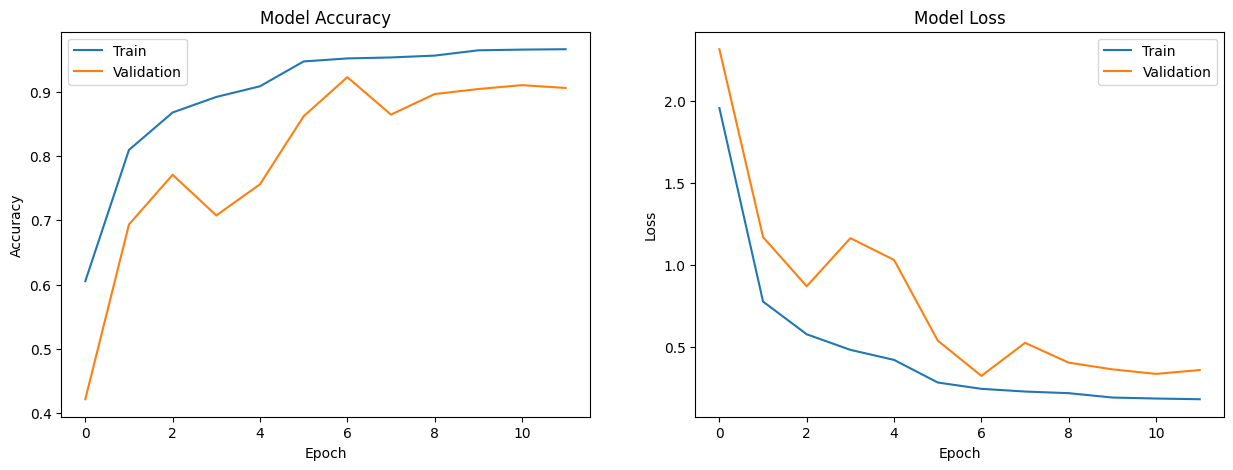

In [23]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_history(history)

Generating predictions
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step


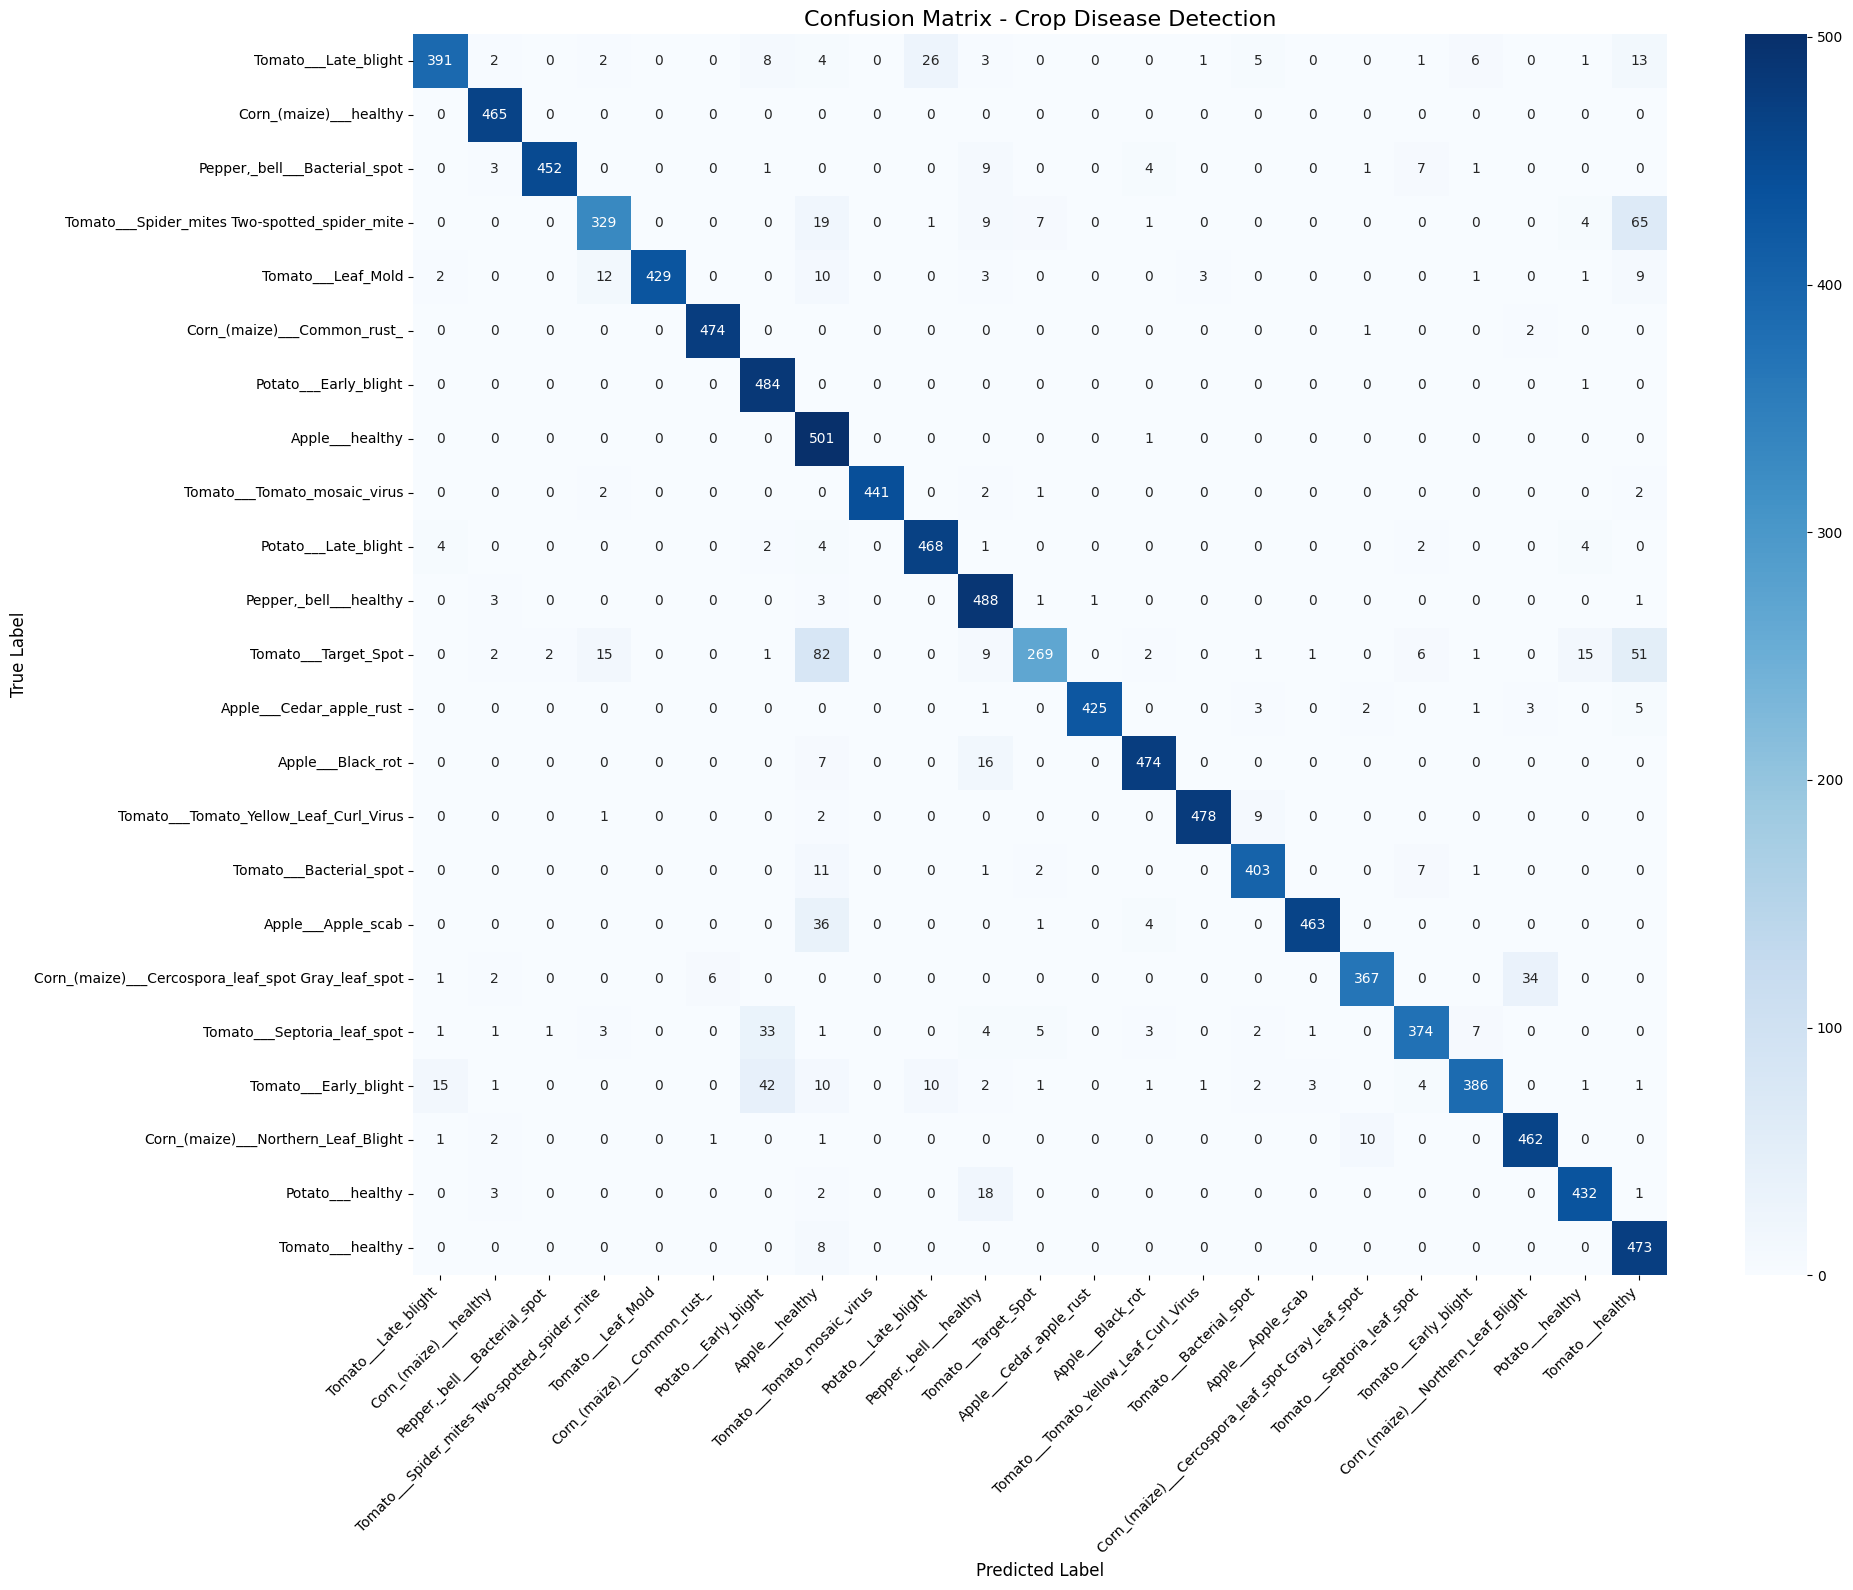


Classification Report:
                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       0.94      0.84      0.89       463
                            Corn_(maize)___healthy       0.96      1.00      0.98       465
                     Pepper,_bell___Bacterial_spot       0.99      0.95      0.97       478
     Tomato___Spider_mites Two-spotted_spider_mite       0.90      0.76      0.82       435
                                Tomato___Leaf_Mold       1.00      0.91      0.95       470
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
                             Potato___Early_blight       0.85      1.00      0.92       485
                                   Apple___healthy       0.71      1.00      0.83       502
                      Tomato___Tomato_mosaic_virus       1.00      0.98      0.99       448
                              Potato___Late_blight     

In [24]:
import seaborn as sns
# Get predictions for all validation samples
print("Generating predictions")
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix - Crop Disease Detection', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Print overall accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"\nOverall Accuracy: {accuracy:.4f}")

In [31]:

TEST_DIR ="/kaggle/input/crop-disease-dataset/disease/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load trained model
model = keras.models.load_model('best_crop_disease_model.h5')

# Make predictions
print("Making predictions on test set...")
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show detailed results
class_names = list(test_generator.class_indices.keys())
print("\nDetailed Results:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Check if model is good for new images
if accuracy >= 0.96:
    print("✅ EXCELLENT: Model will predict new images very well!")
elif accuracy >= 0.90:
    print("✅ GOOD: Model will predict new images well!")
elif accuracy >= 0.80:
    print("⚠️ MODERATE: Model needs improvement")
else:
    print("❌ POOR: Model needs major improvement")

# Predict single image
def predict_single_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_index]
    
    class_names = {v: k for k, v in test_generator.class_indices.items()}
    predicted_class = class_names[predicted_class_index]
    
    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    
    return predicted_class, confidence


# predict_single_image(""/kaggle/input/crop-disease-dataset/disease/train)

Found 0 images belonging to 0 classes.


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_crop_disease_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)